## WISDM
---
- WISDM (Wireless Sensor Data Mining) 데이터셋은 2012년 미국 포덤(Fordham) 대학에서 공개한, 스마트폰 가속도계를 이용한 인간 활동 인식 데이터셋

- 목적: 주머니 속 스마트폰의 가속도계 센서 1개만을 사용해, 36명의 피험자가 수행하는 6가지 일상 활동을 기록.
- 피험자: 36명.
- 센서: 스마트폰 1대 (내장 3축 가속도계만 사용).

---
- 실험 설정 및 센서 구성
    - 센서 위치 (총 1개) 피험자는 스마트폰 1대를 앞쪽 바지 주머니(front pants pocket)에 넣고 활동을 수행. 따라서 PAMAP2와 달리 센서 위치 구분이 없다.
    - 샘플링 속도 (Sampling Rate)
    - 가속도계 (Accelerometer): 20Hz (1초에 20번 측정)
    - 이는 100Hz인 PAMAP2나 50Hz인 UCI-HAR보다 샘플링 속도가 낮다는 것을 의미, 데이터가 상대적으로 덜 촘촘.
---
- 컬럼 상세 (총 6개 컬럼)
    1. subject_id: (int) 피험자 ID (1 ~ 36).
    2. activity_name: (string) 활동 레이블 (타겟 변수). 아래 상세 설명 참조.
    3. timestamp: (long) 시스템 타임스탬프 (나노초).
    4. x_accel: (float) 가속도계 X축 값.
    5. y_accel: (float) 가속도계 Y축 값.
    6. z_accel: (float) 가속도계 Z축 값.

- 주요 특징: PAMAP2나 UCI-HAR(Inertial Signals)와 달리, 이 데이터셋은 **'슬라이딩 윈도우(Sliding Window)'가 적용되지 않은 순수 원시 데이터(raw data)**. 데이터가 128개씩이나 5초씩 잘려있지 않고, 시간순으로 연속적인 스트림(stream) 형태

- 따라서 EDA나 모델링을 위해서는 timestamp와 subject_id를 기준으로 데이터를 정렬한 뒤, 직접 슬라이딩 윈도우를 적용해 1초, 5초 등의 '조각(segment)'으로 만들어주는 전처리가 필수
---
- 타겟 변수: activity_name (총 6개)
    1. Walking
    2. Jogging
    3. Upstairs
    4. Downstairs
    5. Sitting
    6. Standing
---
- 데이터 불균형: WISDM 데이터셋은 Walking과 Jogging 활동의 데이터가 전체의 약 80%를 차지할 정도로 매우 많다. 반면 Upstairs, Downstairs는 데이터가 적은 심각한 클래스 불균형(Class Imbalance)    

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from scipy.fft import fft
from scipy.fft import fftfreq
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [ ]:
# --- 1. 경로 및 파일 설정 ---
# (이전 UCI-HAR에서 사용한 경로를 기반으로 가정)
DATA_PATH = "C://Users/park9/HAR-EDA/"

# WISDM v1.1의 원본 파일명 (파일이 data 폴더 바로 아래 있다고 가정)
# 만약 'WISDM' 같은 하위 폴더에 있다면 경로를 수정해주세요.
# 예: FILE_NAME = r"WISDM\WISDM_ar_v1.1_raw.txt"
FILE_NAME = r"WISDM_ar_v1.1_raw.txt" 
FILE_PATH = os.path.join(DATA_PATH, FILE_NAME)

# --- 2. 컬럼명 정의 ---
# 33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
COLUMN_NAMES = [
    'subject_id', 
    'activity_name', 
    'timestamp', 
    'x_accel', 
    'y_accel', 
    'z_accel' # 마지막 컬럼에 ;가 붙어있음
]

# --- 3. 데이터 로드 ---
try:
    print(f"'{FILE_PATH}' 파일 로드를 시도합니다...")
    
    df_raw = pd.read_csv(
        FILE_PATH,
        header=None,        # 헤더 없음
        names=COLUMN_NAMES, # 정의한 컬럼명 사용
        on_bad_lines='skip' # 가끔 형식이 깨진 줄은 건너뜀
    )
    
    # --- 4. 데이터 클리닝 (가장 중요) ---
    # 마지막 컬럼('z_accel')에 붙어있는 세미콜론(;)을 제거합니다.
    
    # 4-1. z_accel이 문자열(object) 타입인지 확인
    if df_raw['z_accel'].dtype == 'object':
        df_raw['z_accel'] = df_raw['z_accel'].str.rstrip(';').astype(float)
    else:
        # 혹시 숫자로 자동 변환되었다면(이럴 가능성은 낮지만)
        print("z_accel이 이미 숫자형입니다. 클리닝이 필요 없을 수 있습니다.")

    # 4-2. 결측치 확인 및 제거
    # (x, y, z 센서값 중 하나라도 비어있는 행은 EDA에 방해되므로 제거)
    initial_rows = len(df_raw)
    df_raw = df_raw.dropna(subset=['x_accel', 'y_accel', 'z_accel'])
    cleaned_rows = len(df_raw)
    print(f"결측치 제거: {initial_rows - cleaned_rows} 개 행 삭제됨.")

    # --- 5. 로드 결과 확인 ---
    print(f"\n로드 성공! (총 {cleaned_rows} 개 샘플)")
    print("\n데이터 정보 (info):")
    df_raw.info()
    
    print("\n로드된 데이터 (상위 5개):")
    display(df_raw.head())
    
    print("\n고유 활동 및 피험자 수:")
    print(f"Activities: {df_raw['activity_name'].unique()}")
    print(f"Subjects: {df_raw['subject_id'].nunique()} 명")

except FileNotFoundError:
    print(f"Error: 파일을 찾을 수 없습니다! 😱")
    print(f"경로를 확인해주세요: {FILE_PATH}")
except Exception as e:
    print(f"데이터 로드 중 예기치 않은 오류 발생: {e}")

'C://Users/park9/HAR-EDA/WISDM_ar_v1.1_raw.txt' 파일 로드를 시도합니다...
결측치 제거: 1 개 행 삭제됨.

로드 성공! (총 1086465 개 샘플)

데이터 정보 (info):
<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   subject_id     1086465 non-null  int64  
 1   activity_name  1086465 non-null  object 
 2   timestamp      1086465 non-null  int64  
 3   x_accel        1086465 non-null  float64
 4   y_accel        1086465 non-null  float64
 5   z_accel        1086465 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB

로드된 데이터 (상위 5개):


,subject_id,activity_name,timestamp,x_accel,y_accel,z_accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164



고유 활동 및 피험자 수:
Activities: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']
Subjects: 36 명


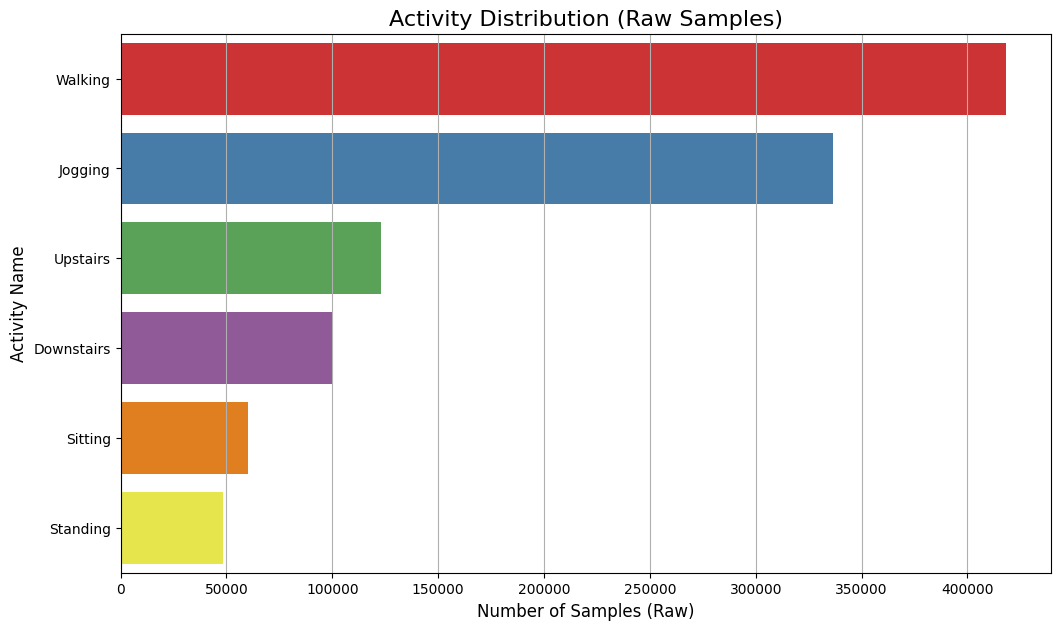

In [6]:
# (df_raw is assumed to be loaded)

plt.figure(figsize=(12, 7))
sns.countplot(
    y='activity_name', 
    data=df_raw, 
    order=df_raw['activity_name'].value_counts().index,
    palette='Set1'
)
plt.title('Activity Distribution (Raw Samples)', fontsize=16)
plt.xlabel('Number of Samples (Raw)', fontsize=12)
plt.ylabel('Activity Name', fontsize=12)
plt.grid(axis='x')
plt.show()

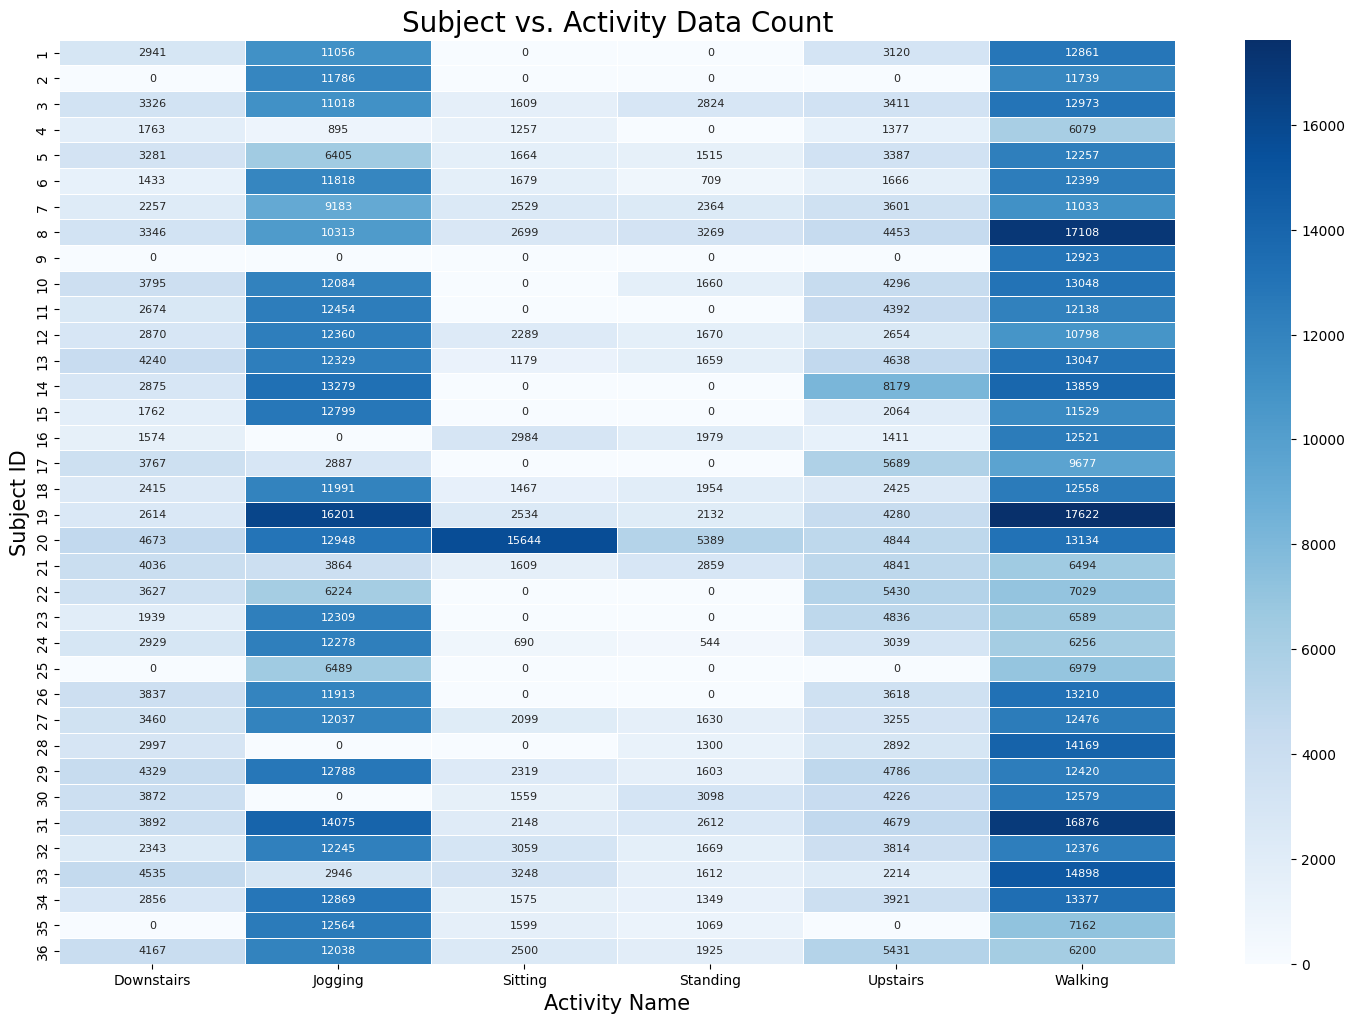

In [8]:
# Aggregate data count by subject_id and activity_name
subject_activity_matrix = df_raw.groupby(['subject_id', 'activity_name'])['timestamp'].count().unstack(fill_value=0)

plt.figure(figsize=(18, 12)) # 36 subjects, so make it tall
sns.heatmap(
    subject_activity_matrix, 
    annot=True, 
    fmt='d',     # Format as integer
    cmap='Blues', 
    linewidths=.5,
    annot_kws={"size": 8} # Adjust font size for clarity
)
plt.title('Subject vs. Activity Data Count', fontsize=20)
plt.xlabel('Activity Name', fontsize=15)
plt.ylabel('Subject ID', fontsize=15)
plt.show()

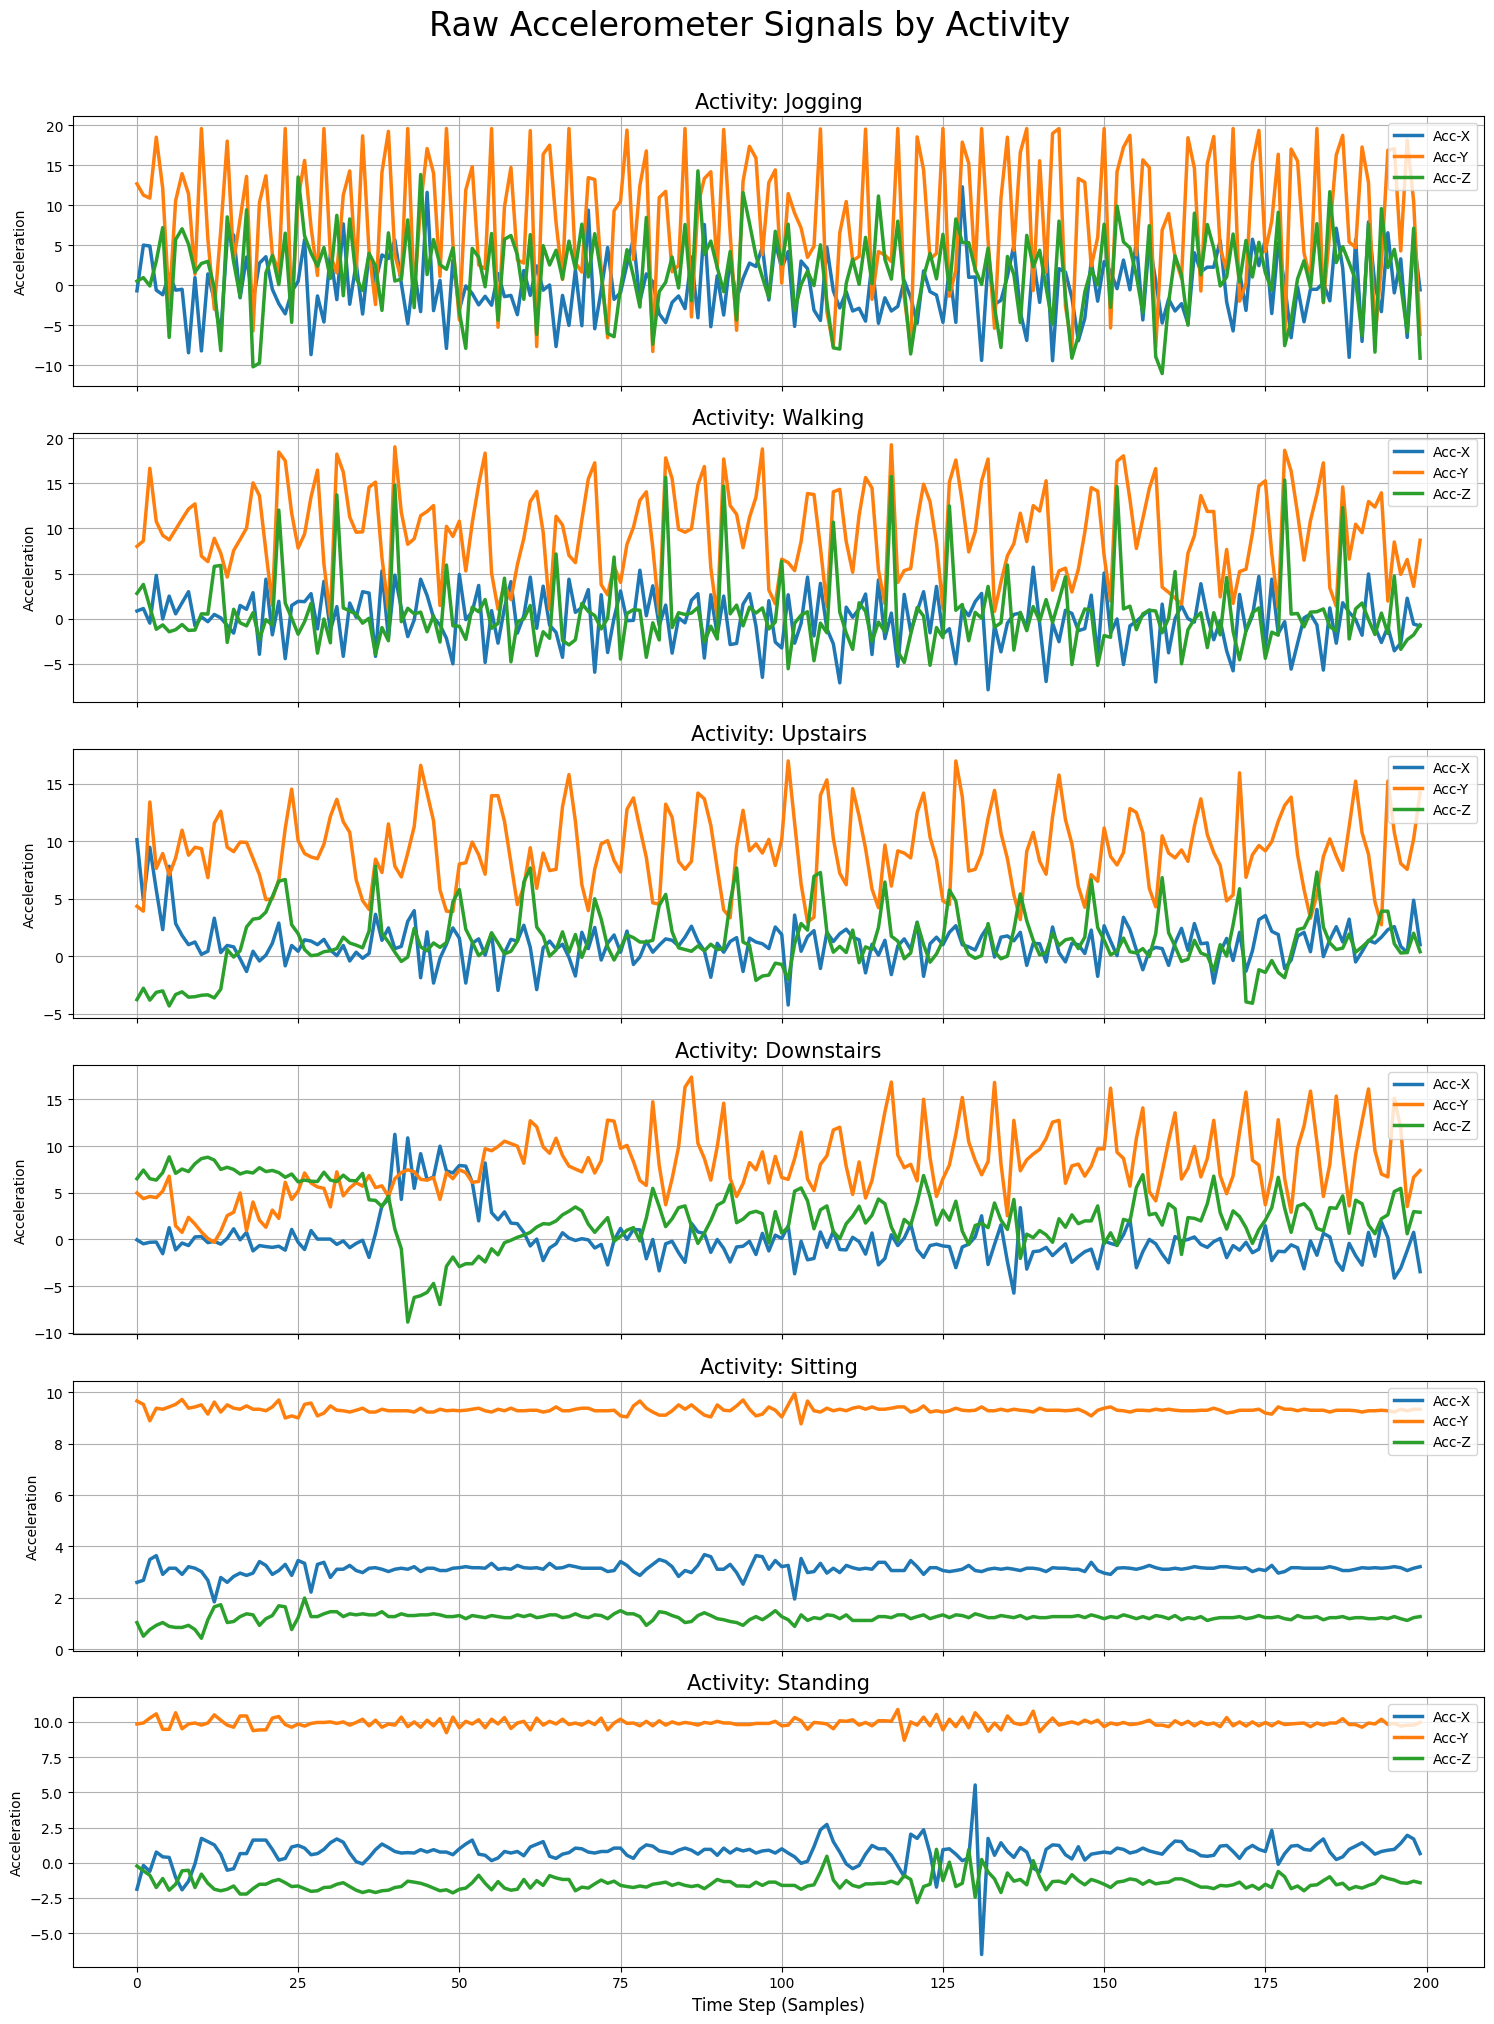

In [18]:
# 6 activity names
activity_names = df_raw['activity_name'].unique()

# Get 200 continuous samples (approx. 10 seconds @ 20Hz) for each activity
samples_to_plot = {}
for activity in activity_names:
    # Get the first 200 samples for this activity
    activity_sample = df_raw[df_raw['activity_name'] == activity].iloc[:200]
    samples_to_plot[activity] = activity_sample

# --- Create Plot ---
fig, axes = plt.subplots(nrows=len(activity_names), ncols=1, figsize=(15, 20), sharex=True)
fig.suptitle('Raw Accelerometer Signals by Activity', fontsize=24, y=1.01)

# X-axis (samples)
time_steps = np.arange(200)

for i, activity_name in enumerate(samples_to_plot.keys()):
    sample_data = samples_to_plot[activity_name]
    
    ax = axes[i]
    ax.plot(time_steps, sample_data['x_accel'], label='Acc-X', linewidth=2.5)
    ax.plot(time_steps, sample_data['y_accel'], label='Acc-Y', linewidth=2.5)
    ax.plot(time_steps, sample_data['z_accel'], label='Acc-Z', linewidth=2.5)
    ax.set_title(f'Activity: {activity_name}', fontsize=15)
    ax.set_ylabel('Acceleration')
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Time Step (Samples)', fontsize=12) # Only set x-label on the last plot
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

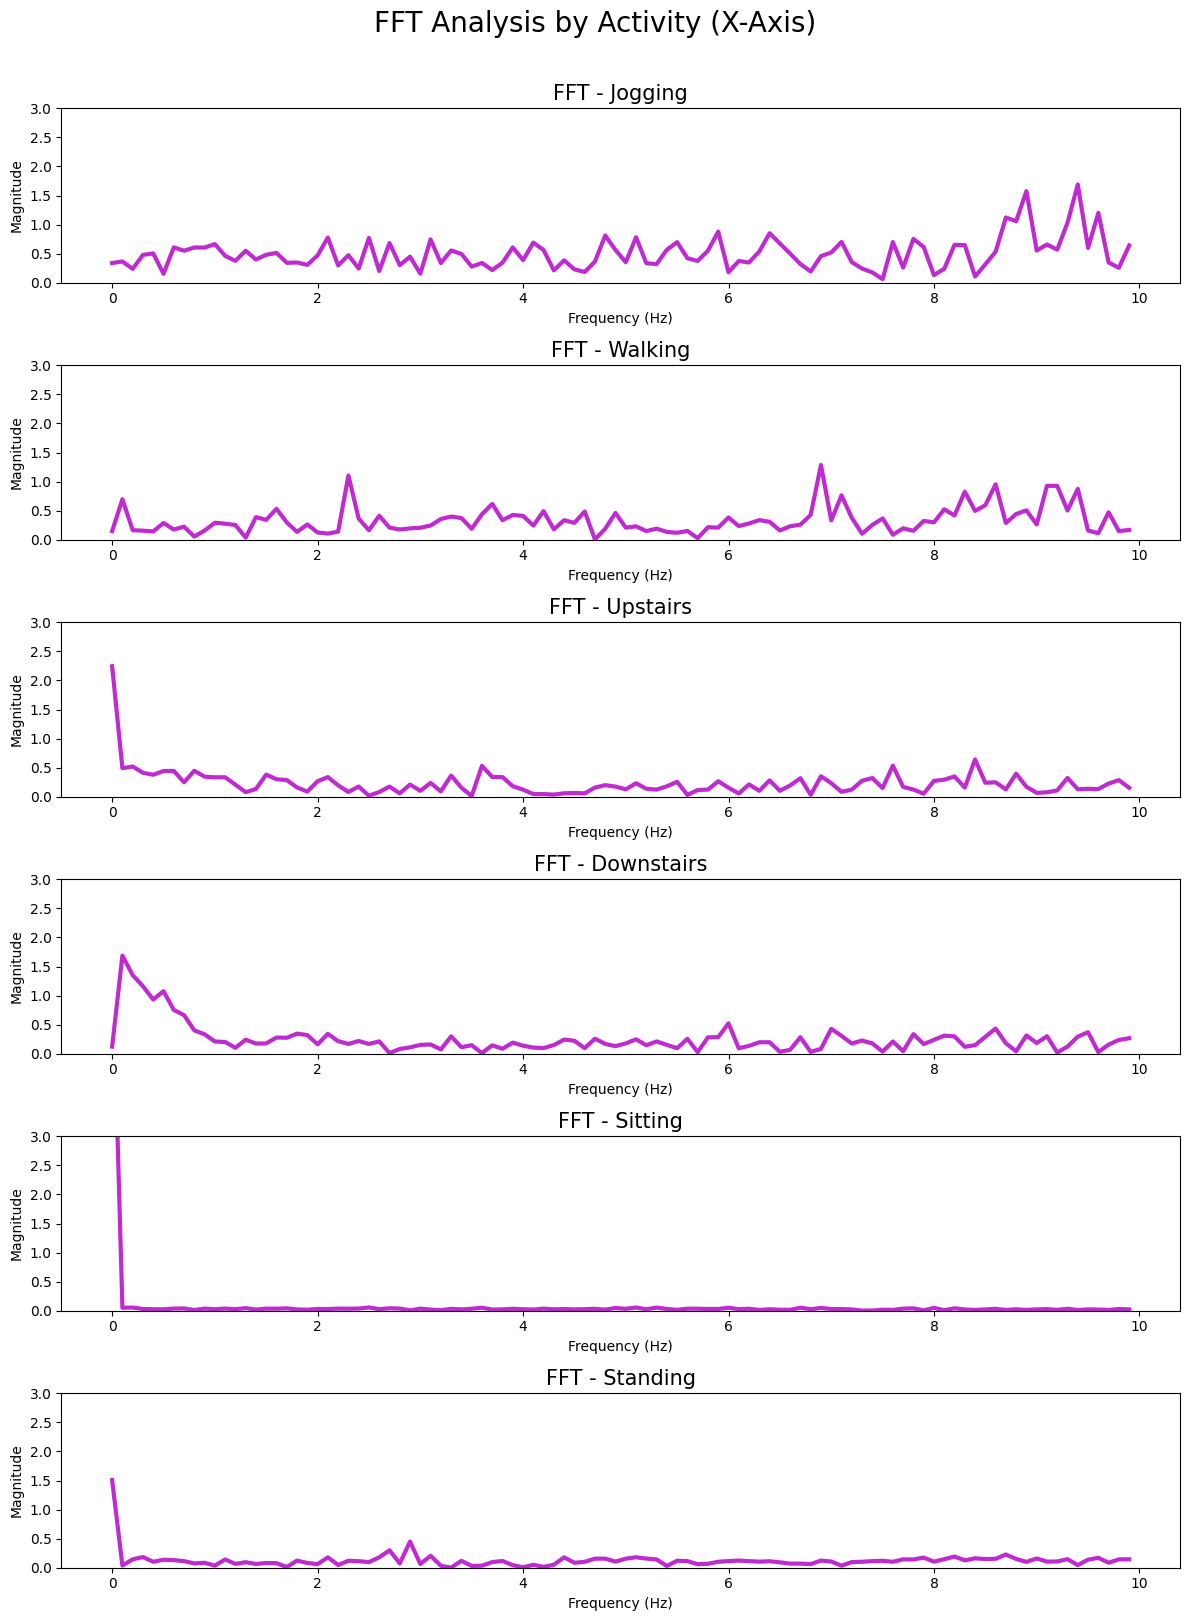

In [12]:
# Sampling Rate (WISDM = 20Hz)
SAMPLING_RATE = 20
# Window Size (We used 200 samples)
N = 200 

fig, axes = plt.subplots(nrows=len(activity_names), ncols=1, figsize=(12, 16))
fig.suptitle('FFT Analysis by Activity (X-Axis)', fontsize=20, y=1.01)

# X-axis (Frequency)
# 20Hz, 200 samples -> 0-10Hz range (Nyquist)
xf = fftfreq(N, 1 / SAMPLING_RATE)[:N//2] # Use N//2

for i, activity_name in enumerate(samples_to_plot.keys()):
    sample_data = samples_to_plot[activity_name]
    
    # Use X-axis signal
    signal = sample_data['x_accel'].values
    
    # Perform FFT
    yf = fft(signal)
    # Calculate Magnitude
    magnitude = 2.0/N * np.abs(yf[0:N//2])

    # Visualization
    ax = axes[i]
    ax.plot(xf, magnitude, '#c02ad1', linewidth=3)
    ax.set_title(f'FFT - {activity_name}', fontsize=15)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_ylim(0, 3) # Fix Y-axis scale for comparison

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [13]:
# --- Settings ---
TIME_STEPS = 100  # 5 seconds * 20 Hz
STEP = 50         # 50% overlap

# --- Function to create windows ---
def create_windows(data, time_steps, step):
    segments = []
    labels = []
    subjects = []
    
    for (subject_id, activity_name), group in data.groupby(['subject_id', 'activity_name']):
        # Extract sensor values
        x = group['x_accel'].values
        y = group['y_accel'].values
        z = group['z_accel'].values
        
        for i in range(0, len(group) - time_steps, step):
            xs = x[i:i + time_steps]
            ys = y[i:i + time_steps]
            zs = z[i:i + time_steps]
            
            # Add segment
            segments.append([xs, ys, zs])
            # Add label
            labels.append(activity_name)
            # Add subject
            subjects.append(subject_id)
            
    # Reshape segments to (N_windows, 100_timesteps, 3_channels)
    reshaped_segments = np.array(segments).transpose(0, 2, 1)
    
    return reshaped_segments, np.array(labels), np.array(subjects)

print("Applying sliding windows to df_raw...")
# (df_raw must be sorted by subject_id and timestamp for this to be safe, 
# but groupby implicitly handles this)
X_windows, y_windows, subjects_windows = create_windows(df_raw, TIME_STEPS, STEP)

print(f"Windowing complete.")
print(f"Windows Shape (X): {X_windows.shape}") # (N_windows, 100, 3)
print(f"Labels Shape (y): {y_windows.shape}")   # (N_windows,)

Applying sliding windows to df_raw...
Windowing complete.
Windows Shape (X): (21455, 100, 3)
Labels Shape (y): (21455,)



DataFrame with Statistical Features (from windows):


,activity_name,subject_id,std_accel_x,std_accel_y,std_accel_z
0,Downstairs,1,3.472834,4.352559,4.515023
1,Downstairs,1,4.493493,4.704742,4.961824
2,Downstairs,1,5.198415,4.908267,4.107469
3,Downstairs,1,5.405137,5.204390,3.650739
4,Downstairs,1,4.983180,5.049842,3.471277


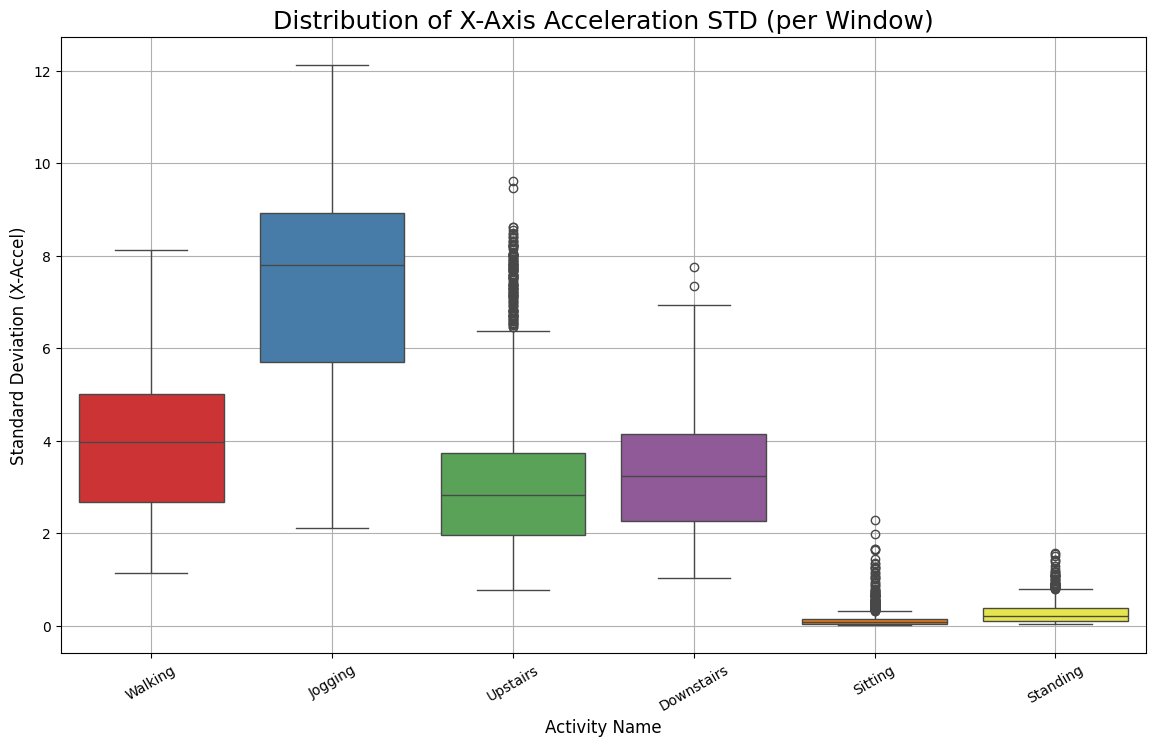

In [15]:
# 1. Calculate statistical features from X_windows
# X_windows shape: (N_windows, 100, 3)
# We calculate std() across the 100 timesteps (axis=1)

# X-axis std (channel 0)
std_x = np.std(X_windows[:, :, 0], axis=1)
# Y-axis std (channel 1)
std_y = np.std(X_windows[:, :, 1], axis=1)
# Z-axis std (channel 2)
std_z = np.std(X_windows[:, :, 2], axis=1)

# 2. Create a new DataFrame for plotting
df_windows_features = pd.DataFrame({
    'activity_name': y_windows,
    'subject_id': subjects_windows,
    'std_accel_x': std_x,
    'std_accel_y': std_y,
    'std_accel_z': std_z
})

print("\nDataFrame with Statistical Features (from windows):")
display(df_windows_features.head())

# 3. Plot Boxplot (e.g., for X-axis std)
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='activity_name', 
    y='std_accel_x', 
    data=df_windows_features,
    order=df_raw['activity_name'].value_counts().index, # Use original order
    palette='Set1'
)
plt.title('Distribution of X-Axis Acceleration STD (per Window)', fontsize=18)
plt.xlabel('Activity Name', fontsize=12)
plt.ylabel('Standard Deviation (X-Accel)', fontsize=12)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

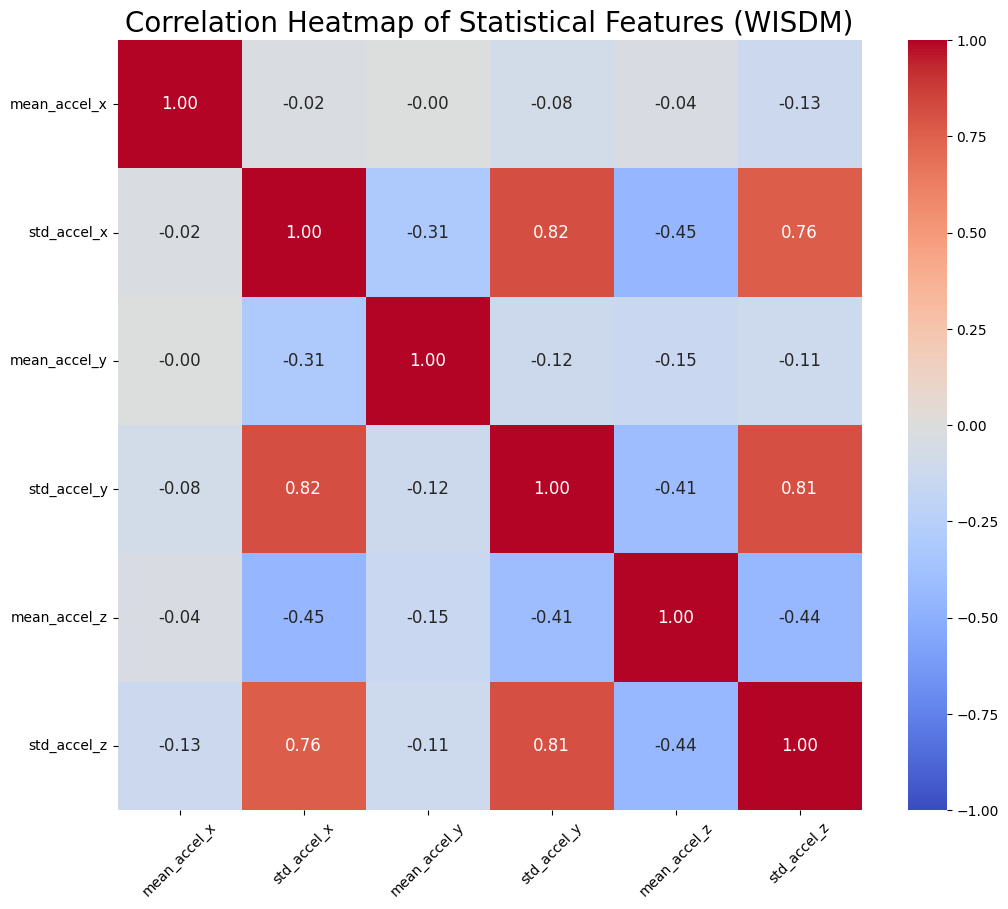

In [16]:
# Calculate more features (mean) for a better heatmap
df_windows_features['mean_accel_x'] = np.mean(X_windows[:, :, 0], axis=1)
df_windows_features['mean_accel_y'] = np.mean(X_windows[:, :, 1], axis=1)
df_windows_features['mean_accel_z'] = np.mean(X_windows[:, :, 2], axis=1)

# Select only feature columns for correlation
features_for_corr = df_windows_features[['mean_accel_x', 'std_accel_x', 
                                          'mean_accel_y', 'std_accel_y', 
                                          'mean_accel_z', 'std_accel_z']]

# Calculate correlation matrix
corr_matrix = features_for_corr.corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    annot_kws={"size": 12},
    fmt='.2f', # Show 2 decimal places
    cmap='coolwarm', 
    vmin=-1, vmax=1 
)
plt.title('Correlation Heatmap of Statistical Features (WISDM)', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()